In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from time import time
import pickle

In [3]:
df = pd.read_csv("dataset.csv")

In [4]:
df.head()

,headline,label
0,Fuck off bitch,-1
1,You're just a slut,-1
2,Whore you don't belong here,-1
3,You dumb cunt stay in your lane,-1
4,Shut up no one wants to hear a stupid woman,-1


In [5]:
df['label'].unique()

array([-1,  0])

Dataframe manipulation

In [6]:
def perform_data_manipulation():
    df = pd.read_csv("dataset.csv")
    
    for index in df.index:
        if df.loc[index, "label"]==-1:
            df.loc[index, "label"] = 1
    return df

In [7]:
df = perform_data_manipulation()

In [8]:
df.head()

,headline,label
0,Fuck off bitch,1
1,You're just a slut,1
2,Whore you don't belong here,1
3,You dumb cunt stay in your lane,1
4,Shut up no one wants to hear a stupid woman,1


In [9]:
df['label'].unique()

array([1, 0])

In [10]:
df.shape[0]

16466

Classification using Pie Chart

In [11]:
def performdatadistribution(df):
    total = df.shape[0]
    num_non_toxic = df[df['label']==0].shape[0]
    
    slices = [num_non_toxic/total, (total-num_non_toxic)/total]
    
    labeling = ['Non-Toxic', 'Toxic']
    
    explode = [0.2, 0]
    
    plt.pie(slices, explode = explode, shadow=True, autopct="%1.1f%%", labels = labeling, wedgeprops={'edgecolor': 'black'})
    
    plt.title('Number of Toxic Vs Non- Toxic Test Sample')
    
    plt.tight_layout()
    
    plt.show()

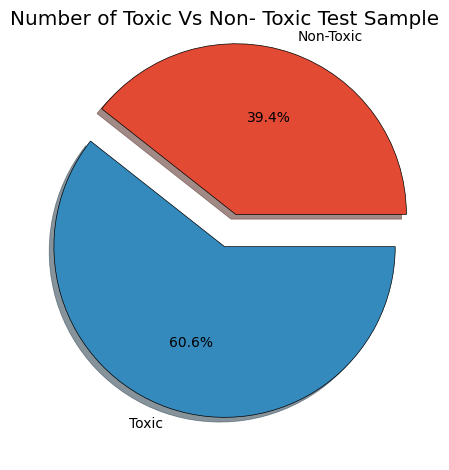

In [12]:
performdatadistribution(df)

In [13]:
def remove_pattern(input_txt, pattern):
    if (type(input_txt)==str):
        r = re.findall(pattern, input_txt)
        for i in r:
            input_txt = re.sub(i, '', input_txt)
        return input_txt
    else:
        return ""

In [14]:
df.head(1)

,headline,label
0,Fuck off bitch,1


In [15]:
def remove_pattern(text, pattern):
    return re.sub(pattern, "", text)

def datasetCleaning(df):
    # Add a new column 'length_headline' with the length of each headline
    df['length_headline'] = df['headline'].str.len()
    
    # Concatenate the DataFrame with itself using pd.concat
    combined_df = pd.concat([df, df], ignore_index=True)
    
    # Remove @user patterns
    combined_df['tidy_tweet'] = np.vectorize(remove_pattern)(combined_df['headline'], "@[\w]*")
    
    # Remove extra letters
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
    
    # Remove all words with size less than 3
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
    
    # Add a column 'length_tidy_tweet' with the length of each cleaned tweet
    combined_df['length_tidy_tweet'] = combined_df['tidy_tweet'].str.len()
    
    # Tokenize the tweets
    tokenized_tweet = combined_df['tidy_tweet'].apply(lambda x: x.split())
    
    # Download necessary NLTK resources
    nltk.download('wordnet')
    
    # Initialize lemmatizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    # Lemmatize the tokens
    tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
    
    # Join tokens back into strings
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
    combined_df['tidy_tweet'] = tokenized_tweet
    
    return combined_df, df
    

<>:12: SyntaxWarning: invalid escape sequence '\w'
<>:12: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Pc\AppData\Local\Temp\ipykernel_43616\7159338.py:12: SyntaxWarning: invalid escape sequence '\w'
  combined_df['tidy_tweet'] = np.vectorize(remove_pattern)(combined_df['headline'], "@[\w]*")


In [16]:
combined_df, df =datasetCleaning(df)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
combined_df.head()

,headline,label,length_headline,tidy_tweet,length_tidy_tweet
0,Fuck off bitch,1,14,Fuck bitch,10
1,You're just a slut,1,18,You're just slut,16
2,Whore you don't belong here,1,27,Whore don't belong here,23
3,You dumb cunt stay in your lane,1,31,dumb cunt stay your lane,24
4,Shut up no one wants to hear a stupid woman,1,43,Shut want hear stupid woman,28


Dataset Splitting

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
def performdatasplit(x, y, combined_df, df):
    X_train, X_test, y_train, y_test = train_test_split(combined_df['tidy_tweet'], combined_df['label'], test_size = x, random_state = y)
    print(f"Number of rows in the total dataset: {combined_df.shape[0]}")
    print(f"Number of rows in the train dataset: {X_train.shape[0]}")
    print(f"Number of rows in the test dataset: {X_test.shape[0]}")
    
    files = open("stopwords.txt" , "r")
    content = files.read()
    content_list = content.split("\n")
    files.close()
    
    tfidfvector = TfidfVectorizer(stop_words=content_list, lowercase=True)
    
    training_data = tfidfvector.fit_transform(X_train.values.astype('U'))
    
    testing_data = tfidfvector.transform(X_test.values.astype('U'))
    
    filename = 'tfidfvectoizer.pkl'
    
    pickle.dump(tfidfvector.vocabulary_, open(filename, 'wb'))
    
    return X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list

In [20]:
X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list = performdatasplit(0.2, 42, combined_df, df)

Number of rows in the total dataset: 32932
Number of rows in the train dataset: 26345
Number of rows in the test dataset: 6587


c:\Users\Pc\Desktop\wieact\SheDetects\envo\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


Apply Machine Learning Algorithm

In [21]:
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [22]:
def pipeline(X_train, y_train, X_test, y_test):
    MODELS = [LinearSVC(), LogisticRegression(), MultinomialNB(), DecisionTreeClassifier(),
              AdaBoostClassifier(), BaggingClassifier(), SGDClassifier()]
    
    size = len(y_train)
    
    results = {}
    
    final_result = []
    
    for model in MODELS:
        results['Algorithm'] = model.__class__.__name__
        
        start = time()
        print(f"Training Time : {model.__class__.__name__}")
        model.fit(X_train, y_train)
        end = time()
        
        filename = model.__class__.__name__+".pkl"
        pickle.dump(model, open(filename, "wb"))
        
        results['Training Time'] = end - start
        
        start = time()
        prediction_test = model.predict(X_test)
        prediction_train = model.predict(X_train)
        end = time()
        
        results['Prediction Time'] = end - start
        
        results['Accuracy : Test'] = accuracy_score(y_test, prediction_test)
        results['Accuracy : Train'] = accuracy_score(y_train, prediction_train)
        
        results['F1 Score : Test'] = f1_score(y_test, prediction_test)
        results['F1 Score : Train'] = f1_score(y_train, prediction_train)
        
        results['Precision : Test'] = precision_score(y_test, prediction_test)
        results['Precision : Train'] = precision_score(y_train, prediction_train)
        
        results['Recall : Test'] = recall_score(y_test, prediction_test)
        results['Recall : Train'] = recall_score(y_train, prediction_train)
        
        print(f"Training {model.__class__.__name__} finished in {results['Training Time']} sec")
        
        final_result.append(results.copy())
    return final_result
        

In [23]:
final_result = pipeline(training_data, y_train, testing_data, y_test)

Training Time : LinearSVC
Training LinearSVC finished in 0.26529550552368164 sec
Training Time : LogisticRegression
Training LogisticRegression finished in 0.5096542835235596 sec
Training Time : MultinomialNB
Training MultinomialNB finished in 0.01598501205444336 sec
Training Time : DecisionTreeClassifier
Training DecisionTreeClassifier finished in 16.676307201385498 sec
Training Time : AdaBoostClassifier


c:\Users\Pc\Desktop\wieact\SheDetects\envo\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training AdaBoostClassifier finished in 7.921880006790161 sec
Training Time : BaggingClassifier
Training BaggingClassifier finished in 145.55622029304504 sec
Training Time : SGDClassifier
Training SGDClassifier finished in 0.12260627746582031 sec


In [24]:
def performfinalresult(final_results):
    results = pd.DataFrame(final_results)
    results.reindex(columns = ['Algorithm', 'Accuracy : Test', 'Precision : Test', 'Recall : Test', 'F1 Score : Test', 'Prediction Time',
                          'Accuracy : Train', 'Precision : Train', 'Recall : Train', 'F1 Score : Train', 'Training Time'])
    results.sort_values(by = 'F1 Score : Test', inplace=True, ascending=False)
    
    return results

In [25]:
results = performfinalresult(final_result)
results.reset_index(drop = True)

,Algorithm,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
0,DecisionTreeClassifier,16.676307,0.082368,0.973888,0.996812,0.978272,0.997365,0.985743,0.999497,0.970913,0.995243
1,BaggingClassifier,145.556220,0.886872,0.968574,0.994800,0.973854,0.995703,0.981166,0.997988,0.966650,0.993428
2,LinearSVC,0.265296,0.008244,0.963261,0.989068,0.969575,0.990981,0.972264,0.991602,0.966901,0.990361
3,LogisticRegression,0.509654,0.000000,0.929406,0.958132,0.940847,0.965252,0.954815,0.971650,0.927282,0.958938
4,SGDClassifier,0.122606,0.004807,0.924245,0.954413,0.935968,0.961949,0.958476,0.973953,0.914493,0.950238
5,MultinomialNB,0.015985,0.008022,0.888568,0.926589,0.911588,0.941419,0.877144,0.912079,0.948847,0.972709
6,AdaBoostClassifier,7.921880,1.524169,0.858206,0.867147,0.872474,0.880928,0.957734,0.964898,0.801153,0.810403


In [26]:
results.describe().loc[['min', 'max'], :]

,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
min,0.015985,0.000000,0.858206,0.867147,0.872474,0.880928,0.877144,0.912079,0.801153,0.810403
max,145.556220,1.524169,0.973888,0.996812,0.978272,0.997365,0.985743,0.999497,0.970913,0.995243


Summary IN Graph

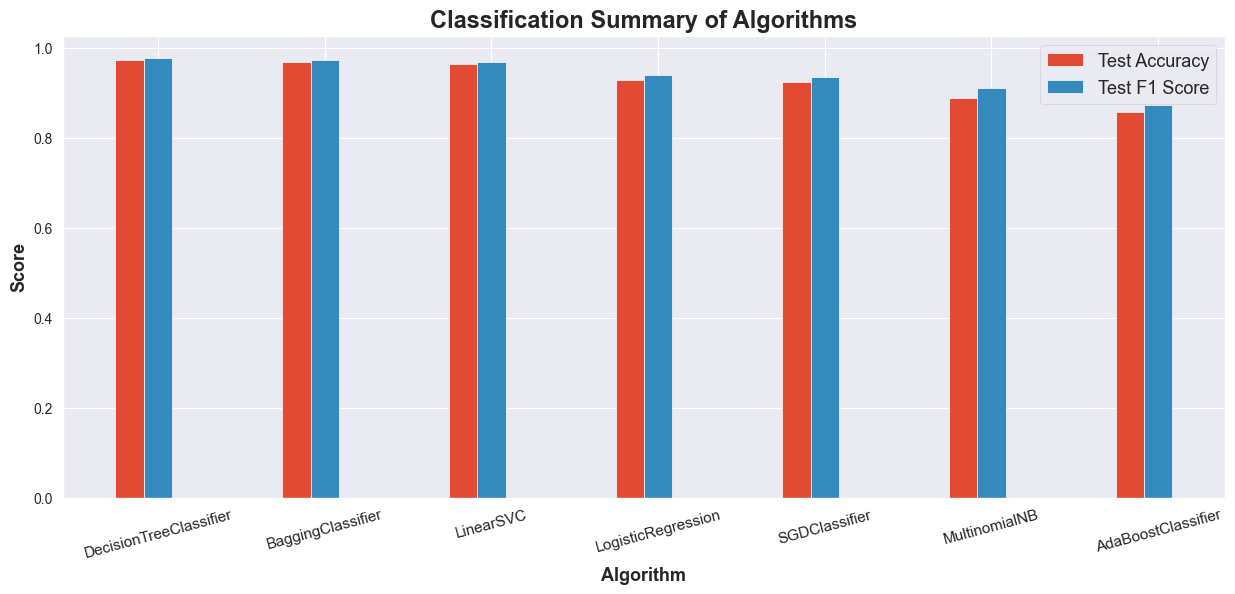

In [27]:
best_acc = results[results['Accuracy : Test'] == results['Accuracy : Test'].max()]
best_f1 = results[results['F1 Score : Test'] == results['F1 Score : Test'].max()]
best_precision = results[results['Precision : Test'] == results['Precision : Test'].max()]
best_recall = results[results['Recall : Test'] == results['Recall : Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (15, 6))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy : Test']
bars2 = results['F1 Score : Test']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Test F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy : Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score : Test'].values[0], best_f1['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

Training and Prediction time of Algorithm

Text(0.5, 1.0, 'Training and Prediction time of Algorithms')

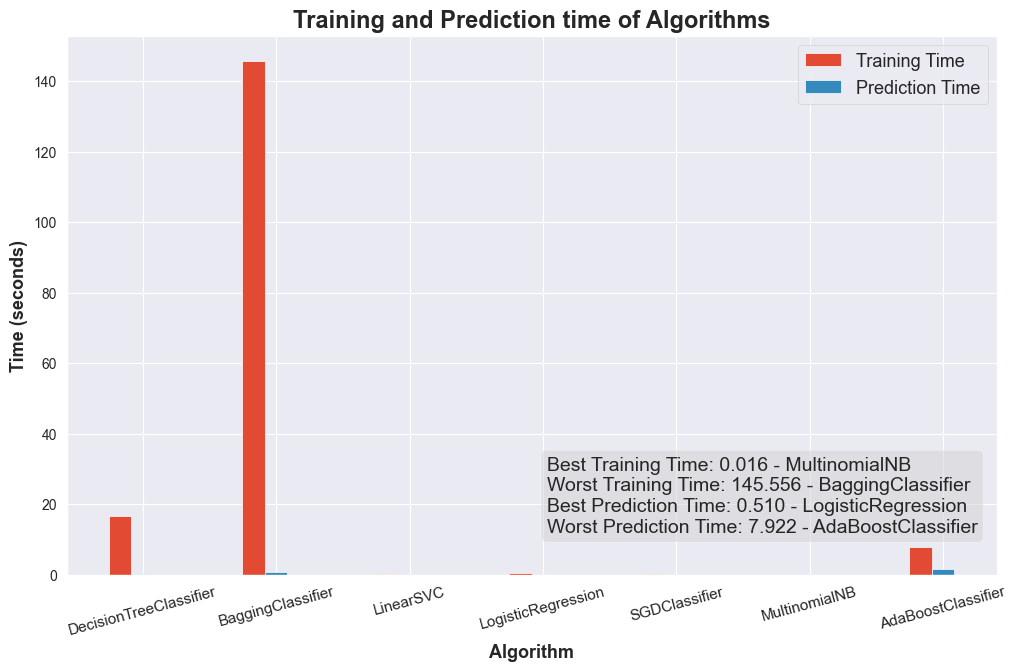

In [28]:

best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)


textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(3.2, 12, textstr, fontsize=14,  bbox=props) 

# Create legend & Show graphic
plt.legend(fontsize = 13)
plt.title('Training and Prediction time of Algorithms', fontweight = 'bold', fontsize = 17)

In [29]:
df.head()

,headline,label,length_headline
0,Fuck off bitch,1,14
1,You're just a slut,1,18
2,Whore you don't belong here,1,27
3,You dumb cunt stay in your lane,1,31
4,Shut up no one wants to hear a stupid woman,1,43


In [30]:
data = ["kal"]
vectorizer = TfidfVectorizer(stop_words=content_list, lowercase=True, vocabulary=pickle.load(open("tfidfvectoizer.pkl", "rb")))
model = pickle.load(open("LinearSVCTuned.pkl", 'rb'))
print(TfidfVectorizer)
print(model)

<class 'sklearn.feature_extraction.text.TfidfVectorizer'>
LinearSVC()


In [31]:
import os

file_path = "LinearSVCTuned.pkl"

if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
    model = pickle.load(open(file_path, 'rb'))
    print("Model loaded successfully!")
else:
    print("Error: File is either missing or empty.")

Model loaded successfully!


Fine Tuining

In [32]:
from sklearn.model_selection import GridSearchCV

def tuining(clf, param_dict, X_train, y_train, X_test, y_test):
    scorer = make_scorer(f1_score)
    
    grid_obj = GridSearchCV(estimator=clf, param_grid=param_dict, scoring=scorer, cv=5)
    
    grid_fit = grid_obj.fit(X_train, y_train)
    
    best_clf = grid_fit.best_estimator_
    
    prediction = (clf.fit(X_train, y_train)).predict(X_test)
    
    best_prediction = best_clf.predict(X_test)
    
    print(clf.__class__.__name__)
    print(f"Best Parameter:  {grid_fit.best_params_}")
    
    print(f"Accuracy:  {accuracy_score(y_test, best_prediction)}")

    print(f"F1 Score :  {f1_score(y_test, best_prediction)}")
    
    print(f"Precision :  {precision_score(y_test, best_prediction)}")
    
    print(f"Recall:  {recall_score(y_test, best_prediction)}")

In [33]:
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_model = LinearSVC()

tuining(clf_model, param_grid, training_data, y_train, testing_data, y_test)

LinearSVC
Best Parameter:  {'C': 1.2}
Accuracy:  0.9646272961894641
F1 Score :  0.9707176071383687
Precision :  0.9730410682791635
Recall:  0.9684052156469408


In [34]:
pickle.dump(clf_model, open("LinearSVCTuned.pkl", "wb"))